In [ ]:
from shapely.geometry import Point
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import rasterio
from pyproj import Transformer

# Getting coordinates from major river flowlines

area_abbr_list = {'Connecticut': 'CT', 'Maine': 'ME', 
                  'Massachusetts': 'MA', 'New_Hampshire': 'NH', 
                  'Rhode Island': 'RI', 'Vermont': 'VT'}

df_id_with_flood = pd.read_csv('data/s2_id_with_flood.csv')

area_in_df = df_id_with_flood['state'].unique().tolist()
area_list = [state for state, abbr in area_abbr_list.items() if abbr in area_in_df]

def read_tif(file_path):
    with rasterio.open(file_path) as src:
        return src.read(), src.bounds, src.crs, src.transform, src.profile
# major_rivers = []

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x168420240> >
{'TIFFTAG_XRESOLUTION': '1', 'TIFFTAG_YRESOLUTION': '1', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'AREA_OR_POINT': 'Area'}
CRS: EPSG:32618
Bands: 3
Band 1: Min=4, Max=255
Band 2: Min=9, Max=255
Band 3: Min=9, Max=255


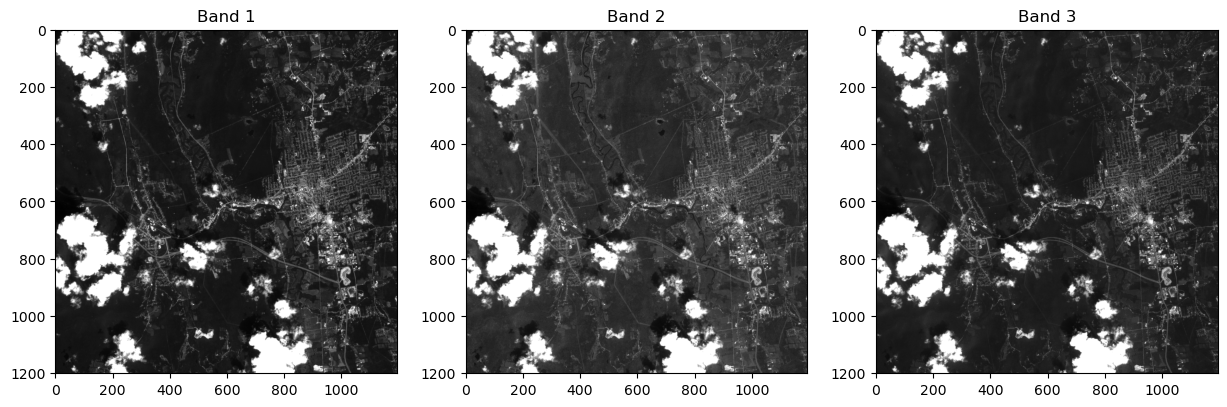

Min/Max values: 4 255
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1195, 'height': 1201, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'), 'transform': Affine(10.0, 0.0, 654250.0,
       0.0, -10.0, 4835920.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}
Data type: ('uint8', 'uint8', 'uint8')


In [11]:
from osgeo import gdal
import matplotlib.pyplot as plt

ds = gdal.Open("data/img_s2/2023-07/44909_20230706T153819_20230706T155055_T18TXP_VIS.tif")
print(ds)
metadata = ds.GetMetadata()
print(metadata)

with rasterio.open("data/img_s2/2023-07/44909_20230706T153819_20230706T155055_T18TXP_VIS.tif") as dataset:
    print("CRS:", dataset.crs)  # Check if it's projected (e.g., EPSG:4326 or UTM)
    print("Bands:", dataset.count)  # Elevation rasters typically have 1 band
    fig, axes = plt.subplots(1, dataset.count, figsize=(15, 5))
    for band in range(1, dataset.count + 1):
        data = dataset.read(band)
        print(f"Band {band}: Min={data.min()}, Max={data.max()}")
        img = dataset.read(band)
        axes[band-1].imshow(img, cmap="gray")
        axes[band-1].set_title(f"Band {band}")
    plt.show()
    print("Min/Max values:", dataset.read(1).min(), dataset.read(1).max())  # Check if values look like elevation

    # Metadata
    print(dataset.profile)
    print("Data type:", dataset.dtypes)

In [ ]:
for i in area_list:
    shp_path = f'data/nhd/{i}/Shape/NHDFlowline.shp'
    
    # flowline['ftype'] or ['y
    # fcode'] (might be helpful for extracting major river?) 
    major_river = [558]
    flowline = gpd.read_file(shp_path)
    major_rivers = flowline[(flowline['ftype'].isin(major_river)) & (flowline['lengthkm'] >= 0.6)]

    distances_list = []

    for _, row in df_id_with_flood.iterrows():
        image_path = os.path.join(row['dir'], row['filename'])
        _, sat_bounds, tiff_crs, _, _  = read_tif(image_path)

        if major_rivers.crs != tiff_crs:
            major_rivers = major_rivers.to_crs(tiff_crs)

        # plot satellite image
        lat = row['latitude']
        lon = row['longitude']
        transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
        raster_x, raster_y = transformer.transform(lon, lat)

        image_center = Point(raster_x, raster_y)
        # print(image_center)

        flowline_coords = []
        for geom in major_rivers.geometry:
            if geom.geom_type == 'LineString':
                flowline_coords.extend(list(geom.coords))
            elif geom.geom_type == 'MultiLineString':
                for line in geom:
                    flowline_coords.extend(list(line.coords))
            
        # Calculate distances for each coordinate pair
        for coord in flowline_coords:
            flowline_point = Point(coord)
            distance = image_center.distance(flowline_point)
            
            # Store the distance with relevant metadata
            distances_list.append({
                'state': i,
                'image_id': row['id'],
                'date': row['date'],
                'flowline_coord': coord,
                'image_file_center': image_center,
                'distance': distance
            })
            # print("flowlinecoords:", coord)    
        print("df row: ", row['id'])
        
        # Create a DataFrame and save as CSV
        df_distances = pd.DataFrame(distances_list)
        flowline_distances = f"distances_{i}_{row['id']}_{row['date']}.csv"
        df_distances.to_csv(f'data/flowline_distance/{flowline_distances}', index=False)
    print("Hopefully state: ",i)

# flowline_coords = []
# for geom in major_rivers.geometry:
#     if geom.geom_type == 'LineString':
#         flowline_coords.append(list(geom.coords))
#     elif geom.geom_type == 'MultiLineString':
#         for line in geom:
#             flowline_coords.append(list(line.coords))

# flowline_coords_np = [np.array(coords) for coords in flowline_coords]

In [3]:
distances_list[0:5]

[{'state': 'Connecticut',
  'image_id': 'ASTN3_326',
  'date': 20230706,
  'flowline_coord': (632423.3949578813, 4530404.649634271, 0.0),
  'distance': 263503.5162553374},
 {'state': 'Connecticut',
  'image_id': 'ASTN3_326',
  'date': 20230706,
  'flowline_coord': (633175.6060427015, 4530743.246802377, 0.0),
  'distance': 262948.0979006295},
 {'state': 'Connecticut',
  'image_id': 'ASTN3_326',
  'date': 20230706,
  'flowline_coord': (633921.9292931367, 4549721.592647873, 0.0),
  'distance': 244724.46680376952},
 {'state': 'Connecticut',
  'image_id': 'ASTN3_326',
  'date': 20230706,
  'flowline_coord': (634119.606763789, 4549129.172737003, 0.0),
  'distance': 245219.0143022699},
 {'state': 'Connecticut',
  'image_id': 'ASTN3_326',
  'date': 20230706,
  'flowline_coord': (630547.0772602472, 4546381.321185898, 0.0),
  'distance': 248998.69216563302}]

In [4]:
import rasterio
import os

image_path = []

for i in area_list:
    # filter the DataFrame for the current state's data during the flood event
    i_abbr = area_abbr_list[i]
    df_i = df_id_with_flood[df_id_with_flood['state'] == i_abbr]
    for _, row in df_i.iterrows():
        image_path.append(os.path.join(row['dir'], row['filename']))

In [5]:
image_path[0:5]

['data/img_s2/2023-07/GAYC3_20_20230706T153819_20230706T155055_T18TXM_VIS.tif',
 'data/img_s2/2023-07/TMVC3_39_20230711T153821_20230711T154201_T18TXM_VIS.tif',
 'data/img_s2/2023-07/TMVC3_39_20230726T153819_20230726T155051_T18TXM_VIS.tif',
 'data/img_s2/2023-07/GAYC3_20_20230711T153821_20230711T154201_T18TXM_VIS.tif',
 'data/img_s2/2023-07/TMVC3_39_20230706T153819_20230706T155055_T18TXM_VIS.tif']

In [6]:
def read_tif(file_path):
    for ip in file_path:
        with rasterio.open(ip) as src:
            return src.read(), src.bounds, src.crs, src.transform, src.profile
        
_, sat_bounds, tiff_crs, _, _ = read_tif(image_path)

In [7]:
# extract the flowline mask

for mr in major_rivers:
    if mr.crs != tiff_crs:
        mr = mr.to_crs(tiff_crs)

In [8]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

def reproject_tif_to_epsg4326(input_tif, output_tif):
    # Open the input file
    with rasterio.open(input_tif) as src:
        # Get the current CRS and transform
        src_crs = src.crs
        transform, width, height = calculate_default_transform(
            src_crs, 'EPSG:4326', src.width, src.height, *src.bounds)
        
        # Update the metadata
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:4326',
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Write the reprojected file
        with rasterio.open(output_tif, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest)

# Reproject all images in the list
for img_path in image_path:
    filename = os.path.basename(img_path)
    output_tif = os.path.join('data/img_s2/output_directory', f"{filename}_4326.tif")
    reproject_tif_to_epsg4326(img_path, output_tif)

output_tif

'data/img_s2/output_directory/45321_20230726T153819_20230726T155051_T18TXN_VIS.tif_4326.tif'

In [9]:
image_path[0]

'data/img_s2/2023-07/GAYC3_20_20230706T153819_20230706T155055_T18TXM_VIS.tif'

In [10]:
import numpy as np

def get_coordinates_from_tif(tif_path):
    with rasterio.open(tif_path) as src:
        # Get dimensions
        width = src.width
        height = src.height
        transform = src.transform
        
        # Create a grid of pixel indices
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        cols_flat = cols.flatten()
        rows_flat = rows.flatten()
        
        # Convert pixel indices to geographical coordinates (lat, lon)
        lons, lats = rasterio.transform.xy(transform, rows_flat, cols_flat)
        coordinates = np.column_stack((lons, lats))
        
    return coordinates

# Get coordinates for all reprojected images
coordinates_list = []
for img_path in image_path:
    output_tif = os.path.join('data/img_s2/output_directory', f"{os.path.basename(img_path)}_4326.tif")
    coords = get_coordinates_from_tif(output_tif)
    coordinates_list.append(coords)

In [11]:
coordinates_list[0:5]

[array([[-73.5631018 ,  41.70797115],
        [-73.56299625,  41.70797115],
        [-73.56289071,  41.70797115],
        ...,
        [-73.41744703,  41.59809679],
        [-73.41734148,  41.59809679],
        [-73.41723594,  41.59809679]]),
 array([[-72.67980995,  42.04273328],
        [-72.67970442,  42.04273328],
        [-72.67959888,  42.04273328],
        ...,
        [-72.53195154,  41.93181308],
        [-72.531846  ,  41.93181308],
        [-72.53174046,  41.93181308]]),
 array([[-72.67980995,  42.04273328],
        [-72.67970442,  42.04273328],
        [-72.67959888,  42.04273328],
        ...,
        [-72.53195154,  41.93181308],
        [-72.531846  ,  41.93181308],
        [-72.53174046,  41.93181308]]),
 array([[-73.5631018 ,  41.70797115],
        [-73.56299625,  41.70797115],
        [-73.56289071,  41.70797115],
        ...,
        [-73.41744703,  41.59809679],
        [-73.41734148,  41.59809679],
        [-73.41723594,  41.59809679]]),
 array([[-72.67980995,  42.0

In [12]:
from haversine import haversine, Unit

# Calculate distance between each flowline point and all points in the first image
distances = []

for flow_pt in flowline_coords_np:
    dists = []
    for img_coords in coordinates_list:
        for img_pt in img_coords:
            # Calculate distance between flowline point and image point
            dist = haversine((flow_pt[1], flow_pt[0]), (img_pt[1], img_pt[0]), unit=Unit.METERS)
            dists.append(dist)
    distances.append(dists)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
distances[0:5]